In [1]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam

In [2]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## EDA

In [3]:
highway = {
    '10': '경부선',
    '100': '남해선(순천-부산)',
    '101': '남해선(영암-순천)',
    '120': '광주대구선',
    '121': '무안광주선',
    '140': '고창담양선',
    '150': '서해안선',
    '160': '울산선',
    '200': '대구포항선',
    '201': '익산장수선',
    '251': '호남선',
    '270': '순천완주선',
    '300': '청주영덕선',
    '301': '당진대전선',
    '351': '통영대전선',
    '352': '중부선',
    '370': '제2중부선',
    '400': '평택제천선',
    '450': '중부내륙선',
    '500': '영동선',
    '550': '중앙선',
    '600': '서울양양선',
    '650': '동해선(삼척-속초)',
    '652': '동해선(부산-포항)',
    '1000': '서울외곽순환선',
    '1020': '남해1지선',
    '1040': '남해2지선',
    '1100': '제2경인선',
    '1200': '경인선',
    '1510': '서천공주선',
    '2510': '호남지선',
    '3000': '대전남부선',
    '4510': '중부내륙지선',
    '5510': '중앙선지선',
    '6000': '부산외곽선',
}

In [4]:
DATASET_PATH = os.path.join('./data')

In [5]:
df_train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
df_train

날짜  시간      10     100    101    120    121   140     150   160  \
0     20200101   0   83247   19128   2611   5161   1588   892   32263  1636   
1     20200101   1   89309   19027   3337   5502   1650  1043   35609  1644   
2     20200101   2   66611   14710   2970   4631   1044   921   26821  1104   
3     20200101   3   53290   13753   2270   4242   1021   790   21322   909   
4     20200101   4   52095   17615   2406   3689   1840   922   22711  1354   
...        ...  ..     ...     ...    ...    ...    ...   ...     ...   ...   
3274  20200517  19  311727  101285  10085  30637  10060  8749  148935  6801   
3275  20200517  20  305354   91426   8607  26021   8095  7198  136503  6147   
3276  20200517  21  306008   75113   6325  19933   5711  4494  129412  5134   
3277  20200517  22  237447   49498   4209  12145   3891  2718   96698  3526   
3278  20200517  23  150312   27410   2350   6406   1803  1614   55788  1849   

      ...  1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
0     ...  1311   3482  11299   7072  1176   3810   748   3920   2133   3799  
1     ...  1162   3849  13180   8771  1283   3763   782   3483   2057   4010  
2     ...   768   2299   7986   5426  1536   3229   491   2634   1526   3388  
3     ...   632   1716   5703   3156  1104   2882   431   2488   1268   3686  
4     ...   875   2421   5816   2933  1206   2433   499   2952   1927   5608  
...   ...   ...    ...    ...    ...   ...    ...   ...    ...    ...    ...  
3274  ...  6726  15431  25597  14292  9300  22238  3786  16936  10729  20194  
3275  ...  5501  15378  24661  14747  8239  20604  3203  15018   9767  17962  
3276  ...  4216  12558  22781  14081  6392  17937  2447  12403   7825  14031  
3277  ...  2578   8870  16640  11066  4427  11955  1495   7507   5387   8889  
3278  ...  1377   5021  10058   7139  2250   6844   735   4116   3046   4606  

[3279 rows x 37 columns]

In [6]:
df_val = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
df_val

날짜  시간      10    100    101    120   121   140     150   160  ...  \
0    20200511   0   77968  14429   1233   4021   981   881   28672  1064  ...   
1    20200511   1   48679   9136    823   2618   654   572   17722   672  ...   
2    20200511   2   33773   8199    578   2188   392   502   14464   579  ...   
3    20200511   3   41511   9986    726   2817   555   646   17793   650  ...   
4    20200511   4   78680  19509   1463   4720   825  1088   35125   997  ...   
..        ...  ..     ...    ...    ...    ...   ...   ...     ...   ...  ...   
331  20200524  19  314226  98345  10625  28618  8316  6684  141675  6619  ...   
332  20200524  20  300001  87871   8226  22706  6981  5743  142933  6295  ...   
333  20200524  21  304150  71126   6002  18317  4939  3779  133110  4781  ...   
334  20200524  22  236751  44947   3575  11455  3135  2536   98582  3267  ...   
335  20200524  23  143609  26137   2242   6166  1609  1391   54633  1899  ...   

     1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
0     637   2604   5239   4168  1155   3596   337   2262   1608   2337  
1     353   1870   3359   2558  1002   2157   257   1425   1018   1810  
2     345   1499   2646   2022   876   1959   232   1155    927   1530  
3     390   1730   3398   1967   912   2462   281   1477    959   1882  
4     679   2958   7369   4120  1569   4568   577   3155   1871   3656  
..    ...    ...    ...    ...   ...    ...   ...    ...    ...    ...  
331  8254  16118  23304  14082  8447  21694  2180  15746  10903  21014  
332  5225  15297  21919  14526  7332  19732  1990  14096  10028  17787  
333  4072  12685  21135  14403  5443  16967  1359  11670   7963  14041  
334  2489   8093  14427  10914  3861  11397   859   7270   5194   8230  
335  1343   4686   8732   6986  2161   6487   410   3963   2686   4690  

[336 rows x 37 columns]

In [20]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   날짜      336 non-null    int64
 1   시간      336 non-null    int64
 2   10      336 non-null    int64
 3   100     336 non-null    int64
 4   101     336 non-null    int64
 5   120     336 non-null    int64
 6   121     336 non-null    int64
 7   140     336 non-null    int64
 8   150     336 non-null    int64
 9   160     336 non-null    int64
 10  200     336 non-null    int64
 11  201     336 non-null    int64
 12  251     336 non-null    int64
 13  270     336 non-null    int64
 14  300     336 non-null    int64
 15  301     336 non-null    int64
 16  351     336 non-null    int64
 17  352     336 non-null    int64
 18  370     336 non-null    int64
 19  400     336 non-null    int64
 20  450     336 non-null    int64
 21  500     336 non-null    int64
 22  550     336 non-null    int64
 23  600     336 non

In [7]:
df_val[df_val['날짜'] > 20200517]

날짜  시간      10    100    101    120   121   140     150   160  ...  \
168  20200518   0   82065  15172   1500   3294  1086   962   28931  1103  ...   
169  20200518   1   51248   9840    813   2356   696   546   17888   720  ...   
170  20200518   2   39026   7894    760   2413   408   549   13357   498  ...   
171  20200518   3   40993  10137    780   2701   420   741   15544   532  ...   
172  20200518   4   77863  19603   1276   5019   968  1160   32101   968  ...   
..        ...  ..     ...    ...    ...    ...   ...   ...     ...   ...  ...   
331  20200524  19  314226  98345  10625  28618  8316  6684  141675  6619  ...   
332  20200524  20  300001  87871   8226  22706  6981  5743  142933  6295  ...   
333  20200524  21  304150  71126   6002  18317  4939  3779  133110  4781  ...   
334  20200524  22  236751  44947   3575  11455  3135  2536   98582  3267  ...   
335  20200524  23  143609  26137   2242   6166  1609  1391   54633  1899  ...   

     1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
168   618   2790   5147   4331  1329   3665   404   2242   1619   2314  
169   430   1864   3269   2561   921   2081   272   1390   1003   1766  
170   322   1313   2765   1931   920   1764   228   1136    922   1309  
171   326   1766   3320   2060   892   2447   337   1495    975   1912  
172   669   2914   6986   3911  1368   4380   513   2940   1758   3629  
..    ...    ...    ...    ...   ...    ...   ...    ...    ...    ...  
331  8254  16118  23304  14082  8447  21694  2180  15746  10903  21014  
332  5225  15297  21919  14526  7332  19732  1990  14096  10028  17787  
333  4072  12685  21135  14403  5443  16967  1359  11670   7963  14041  
334  2489   8093  14427  10914  3861  11397   859   7270   5194   8230  
335  1343   4686   8732   6986  2161   6487   410   3963   2686   4690  

[168 rows x 37 columns]

In [8]:
df_train = pd.concat([df_train, df_val[df_val['날짜'] > 20200517]], ignore_index=True)
df_train

날짜  시간      10    100    101    120   121   140     150   160  \
0     20200101   0   83247  19128   2611   5161  1588   892   32263  1636   
1     20200101   1   89309  19027   3337   5502  1650  1043   35609  1644   
2     20200101   2   66611  14710   2970   4631  1044   921   26821  1104   
3     20200101   3   53290  13753   2270   4242  1021   790   21322   909   
4     20200101   4   52095  17615   2406   3689  1840   922   22711  1354   
...        ...  ..     ...    ...    ...    ...   ...   ...     ...   ...   
3442  20200524  19  314226  98345  10625  28618  8316  6684  141675  6619   
3443  20200524  20  300001  87871   8226  22706  6981  5743  142933  6295   
3444  20200524  21  304150  71126   6002  18317  4939  3779  133110  4781   
3445  20200524  22  236751  44947   3575  11455  3135  2536   98582  3267   
3446  20200524  23  143609  26137   2242   6166  1609  1391   54633  1899   

      ...  1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
0     ...  1311   3482  11299   7072  1176   3810   748   3920   2133   3799  
1     ...  1162   3849  13180   8771  1283   3763   782   3483   2057   4010  
2     ...   768   2299   7986   5426  1536   3229   491   2634   1526   3388  
3     ...   632   1716   5703   3156  1104   2882   431   2488   1268   3686  
4     ...   875   2421   5816   2933  1206   2433   499   2952   1927   5608  
...   ...   ...    ...    ...    ...   ...    ...   ...    ...    ...    ...  
3442  ...  8254  16118  23304  14082  8447  21694  2180  15746  10903  21014  
3443  ...  5225  15297  21919  14526  7332  19732  1990  14096  10028  17787  
3444  ...  4072  12685  21135  14403  5443  16967  1359  11670   7963  14041  
3445  ...  2489   8093  14427  10914  3861  11397   859   7270   5194   8230  
3446  ...  1343   4686   8732   6986  2161   6487   410   3963   2686   4690  

[3447 rows x 37 columns]

In [9]:
df_train['날짜'].value_counts()

20200101    24
20200102    24
20200403    24
20200404    24
20200405    24
            ..
20200220    24
20200221    24
20200524    24
20200229    13
20200330     2
Name: 날짜, Length: 145, dtype: int64

In [12]:
df_train['datetime'] = df_train.apply(lambda x: pd.to_datetime(f"{x.loc['날짜']}{x.loc['시간']:02d}", format='%Y%m%d%H'), axis=1)
df_train

날짜  시간      10    100    101    120   121   140     150   160  \
0     20200101   0   83247  19128   2611   5161  1588   892   32263  1636   
1     20200101   1   89309  19027   3337   5502  1650  1043   35609  1644   
2     20200101   2   66611  14710   2970   4631  1044   921   26821  1104   
3     20200101   3   53290  13753   2270   4242  1021   790   21322   909   
4     20200101   4   52095  17615   2406   3689  1840   922   22711  1354   
...        ...  ..     ...    ...    ...    ...   ...   ...     ...   ...   
3442  20200524  19  314226  98345  10625  28618  8316  6684  141675  6619   
3443  20200524  20  300001  87871   8226  22706  6981  5743  142933  6295   
3444  20200524  21  304150  71126   6002  18317  4939  3779  133110  4781   
3445  20200524  22  236751  44947   3575  11455  3135  2536   98582  3267   
3446  20200524  23  143609  26137   2242   6166  1609  1391   54633  1899   

      ...   1040   1100   1200  1510   2510  3000   4510   5510   6000  \
0     ...   3482  11299   7072  1176   3810   748   3920   2133   3799   
1     ...   3849  13180   8771  1283   3763   782   3483   2057   4010   
2     ...   2299   7986   5426  1536   3229   491   2634   1526   3388   
3     ...   1716   5703   3156  1104   2882   431   2488   1268   3686   
4     ...   2421   5816   2933  1206   2433   499   2952   1927   5608   
...   ...    ...    ...    ...   ...    ...   ...    ...    ...    ...   
3442  ...  16118  23304  14082  8447  21694  2180  15746  10903  21014   
3443  ...  15297  21919  14526  7332  19732  1990  14096  10028  17787   
3444  ...  12685  21135  14403  5443  16967  1359  11670   7963  14041   
3445  ...   8093  14427  10914  3861  11397   859   7270   5194   8230   
3446  ...   4686   8732   6986  2161   6487   410   3963   2686   4690   

                datetime  
0    2020-01-01 00:00:00  
1    2020-01-01 01:00:00  
2    2020-01-01 02:00:00  
3    2020-01-01 03:00:00  
4    2020-01-01 04:00:00  
...                  ...  
3442 2020-05-24 19:00:00  
3443 2020-05-24 20:00:00  
3444 2020-05-24 21:00:00  
3445 2020-05-24 22:00:00  
3446 2020-05-24 23:00:00  

[3447 rows x 38 columns]

In [13]:
weekday = ['월', '화', '수', '목', '금', '토', '일']
df_train['요일'] = df_train['datetime'].apply(lambda x: weekday[x.dayofweek])
df_train

날짜  시간      10    100    101    120   121   140     150   160  \
0     20200101   0   83247  19128   2611   5161  1588   892   32263  1636   
1     20200101   1   89309  19027   3337   5502  1650  1043   35609  1644   
2     20200101   2   66611  14710   2970   4631  1044   921   26821  1104   
3     20200101   3   53290  13753   2270   4242  1021   790   21322   909   
4     20200101   4   52095  17615   2406   3689  1840   922   22711  1354   
...        ...  ..     ...    ...    ...    ...   ...   ...     ...   ...   
3442  20200524  19  314226  98345  10625  28618  8316  6684  141675  6619   
3443  20200524  20  300001  87871   8226  22706  6981  5743  142933  6295   
3444  20200524  21  304150  71126   6002  18317  4939  3779  133110  4781   
3445  20200524  22  236751  44947   3575  11455  3135  2536   98582  3267   
3446  20200524  23  143609  26137   2242   6166  1609  1391   54633  1899   

      ...   1100   1200  1510   2510  3000   4510   5510   6000  \
0     ...  11299   7072  1176   3810   748   3920   2133   3799   
1     ...  13180   8771  1283   3763   782   3483   2057   4010   
2     ...   7986   5426  1536   3229   491   2634   1526   3388   
3     ...   5703   3156  1104   2882   431   2488   1268   3686   
4     ...   5816   2933  1206   2433   499   2952   1927   5608   
...   ...    ...    ...   ...    ...   ...    ...    ...    ...   
3442  ...  23304  14082  8447  21694  2180  15746  10903  21014   
3443  ...  21919  14526  7332  19732  1990  14096  10028  17787   
3444  ...  21135  14403  5443  16967  1359  11670   7963  14041   
3445  ...  14427  10914  3861  11397   859   7270   5194   8230   
3446  ...   8732   6986  2161   6487   410   3963   2686   4690   

                datetime  요일  
0    2020-01-01 00:00:00   수  
1    2020-01-01 01:00:00   수  
2    2020-01-01 02:00:00   수  
3    2020-01-01 03:00:00   수  
4    2020-01-01 04:00:00   수  
...                  ...  ..  
3442 2020-05-24 19:00:00   일  
3443 2020-05-24 20:00:00   일  
3444 2020-05-24 21:00:00   일  
3445 2020-05-24 22:00:00   일  
3446 2020-05-24 23:00:00   일  

[3447 rows x 39 columns]

In [14]:
temp = df_train[df_train['날짜'].isin([20200229, 20200330])]
temp

날짜  시간      10    100    101    120    121   140     150   160  \
1416  20200229   0   70783  12481   1074   2920   1020   956   26231   677   
1417  20200229   1   51754   8195    694   2141    617   703   19200   593   
1418  20200229   2   41031   7143    641   1936    597   595   14281   416   
1419  20200229   3   37688   7626    624   1742    420   500   13834   442   
1420  20200229   4   46899  11199    781   2720    651   653   18429   609   
1421  20200229   5   80770  20795   1717   4251   1385  1018   38419  1110   
1422  20200229   6  126497  35718   3163   6909   3872  1840   57764  1882   
1423  20200229   7  156874  51431   4414  10409   5324  3191   72190  2940   
1424  20200229   8  189865  57387   5271  12740   5784  3666  100060  3474   
1425  20200229   9  229212  70651   7700  15575   7699  4894  110886  4191   
1426  20200229  10  263691  86077   9788  19358   9699  5749  142355  4654   
1427  20200229  11  273499  87255  10618  20799  10645  6216  140001  5069   
1428  20200229  12  262765  85231  10054  20610   9954  6649  132783  5147   
2125  20200330   0   38243   7403    585   1695    426   351   13476   430   
2126  20200330   1   20378   3927    313   1060    315   223    7095   287   

      ...   1100   1200  1510   2510  3000   4510  5510   6000  \
1416  ...   7873   5389  1026   3447   401   1706  1381   1872   
1417  ...   5193   3925   866   2685   231   1240  1014   1428   
1418  ...   4047   2893   800   2313   237   1107   848   1307   
1419  ...   3915   2283   636   2083   201   1257   807   1181   
1420  ...   5882   2999   705   2737   391   1888  1163   1797   
1421  ...  13280   7195   912   3920   542   3485  2561   4000   
1422  ...  19922  10239  1737   5548   895   7021  4730   8105   
1423  ...  22121  11850  2424   7812  1407  10988  6980  11540   
1424  ...  26327  15156  3405  10854  1697  11589  7241  12127   
1425  ...  30064  16810  4651  13805  1932  11631  8396  14127   
1426  ...  32248  17247  6034  17461  2199  12876  9490  16803   
1427  ...  34208  17590  6678  18613  2364  13056  9886  17624   
1428  ...  34449  18176  6894  17306  2230  12745  9629  17548   
2125  ...   2574   2011   521   1662   139    950   761   1130   
2126  ...   1220   1040   348    980    83    602   358    685   

                datetime  요일  
1416 2020-02-29 00:00:00   토  
1417 2020-02-29 01:00:00   토  
1418 2020-02-29 02:00:00   토  
1419 2020-02-29 03:00:00   토  
1420 2020-02-29 04:00:00   토  
1421 2020-02-29 05:00:00   토  
1422 2020-02-29 06:00:00   토  
1423 2020-02-29 07:00:00   토  
1424 2020-02-29 08:00:00   토  
1425 2020-02-29 09:00:00   토  
1426 2020-02-29 10:00:00   토  
1427 2020-02-29 11:00:00   토  
1428 2020-02-29 12:00:00   토  
2125 2020-03-30 00:00:00   월  
2126 2020-03-30 01:00:00   월  

[15 rows x 39 columns]

In [16]:
from matplotlib import pyplot as plt

plt.rc('figure', figsize=(16, 8))
plt.rc('font', family='Noto Sans KR')

/tmp/ipykernel_10151/3909241128.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


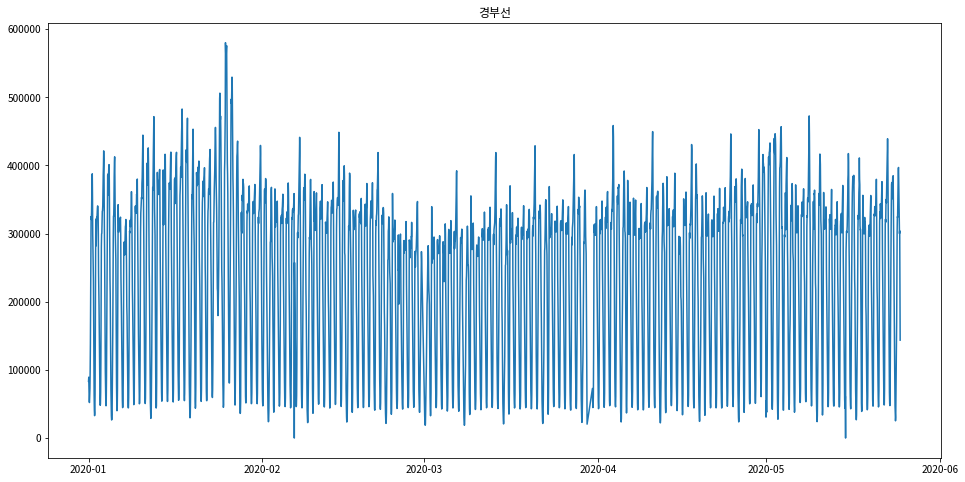

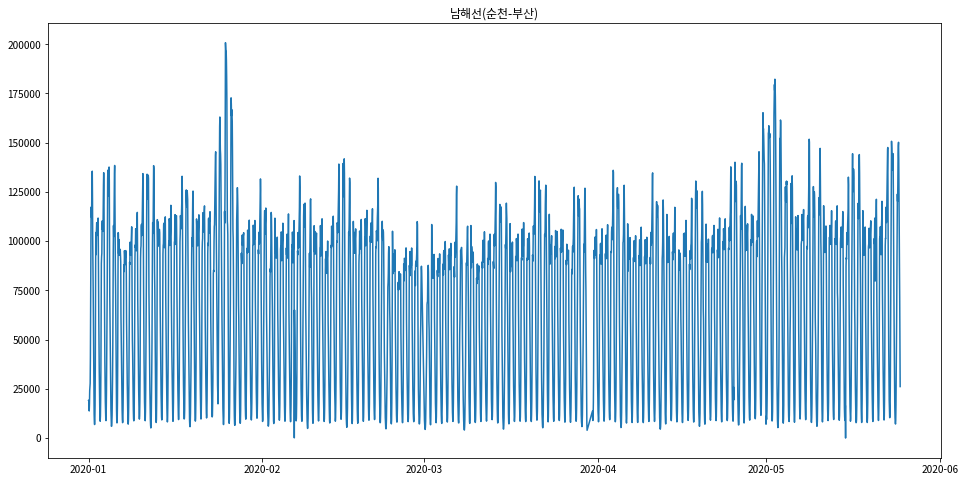

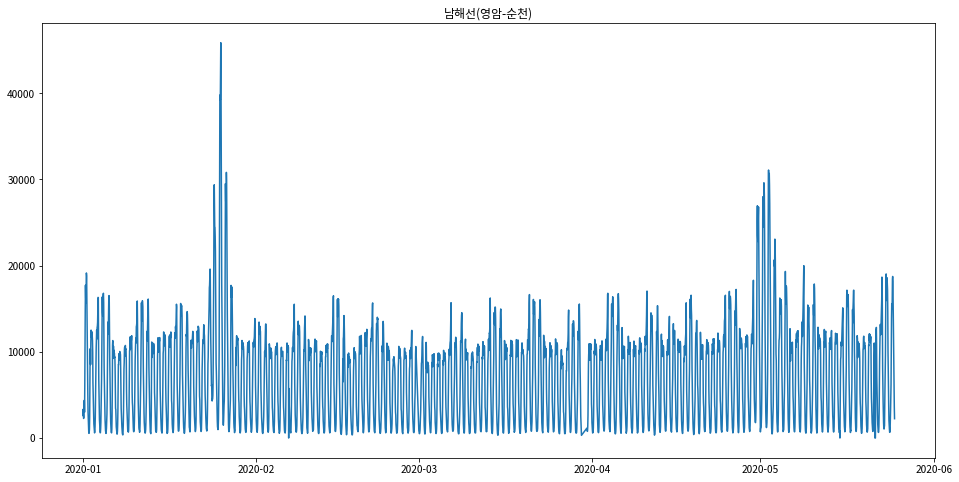

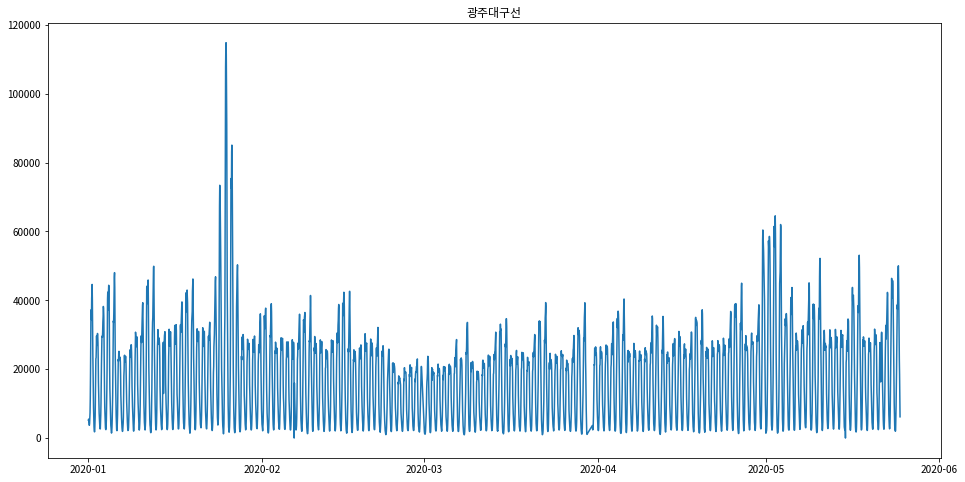

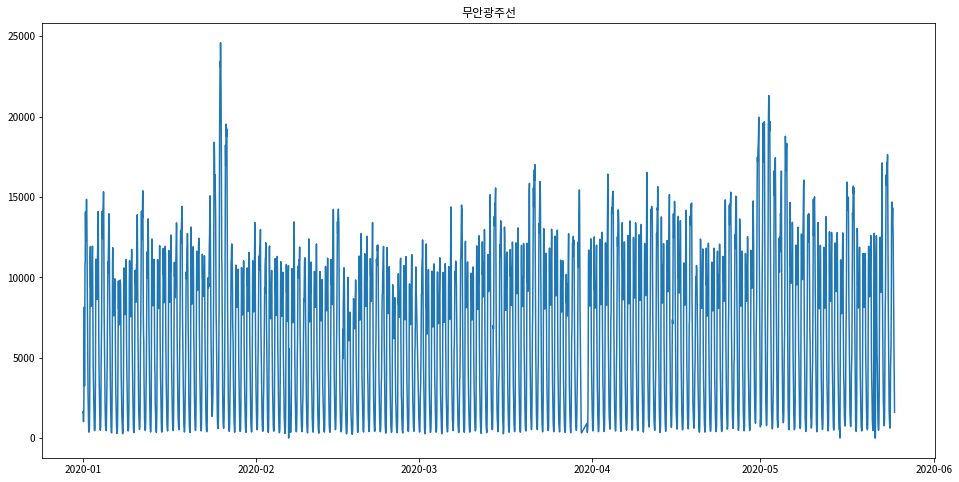

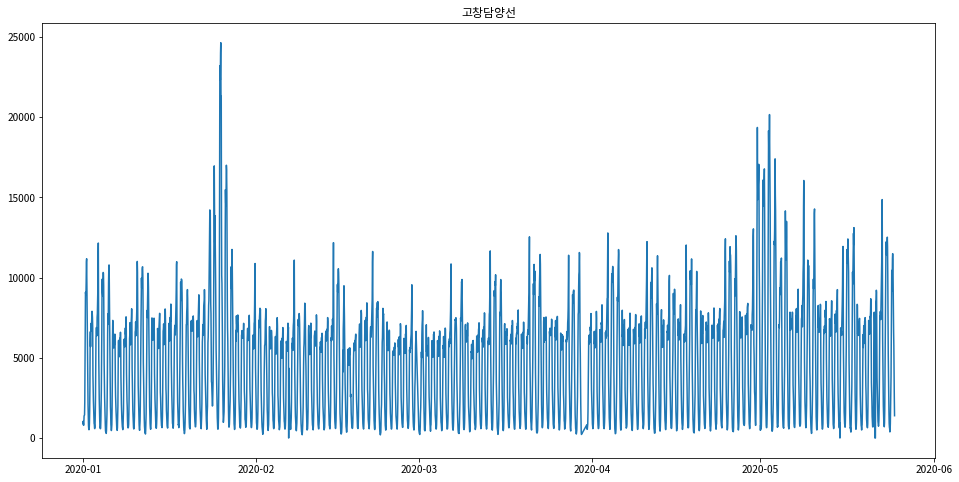

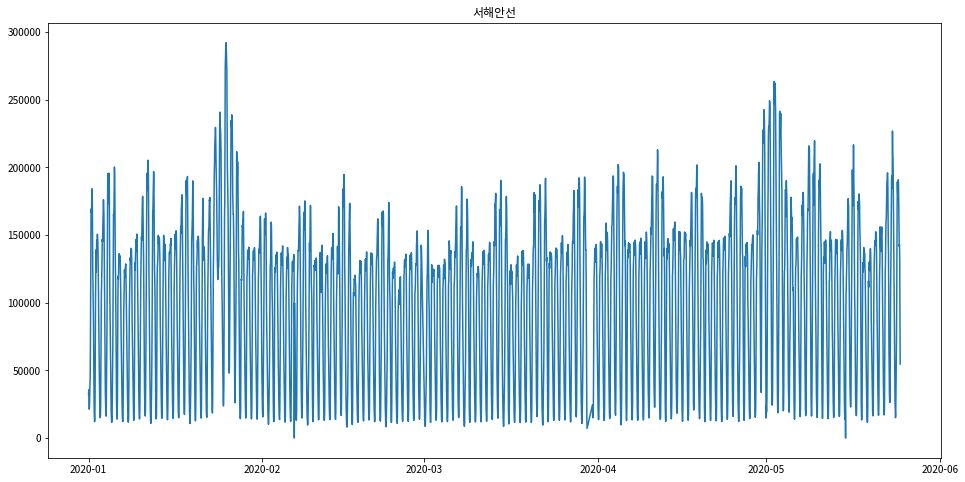

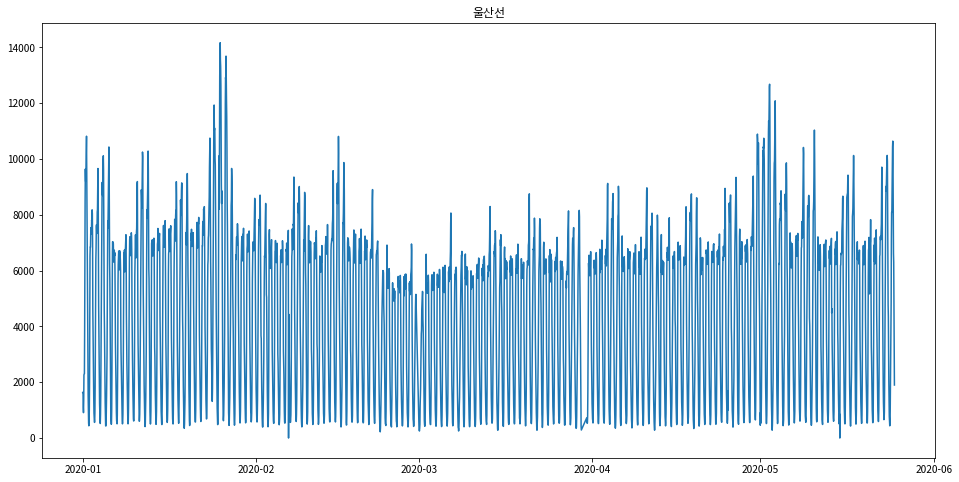

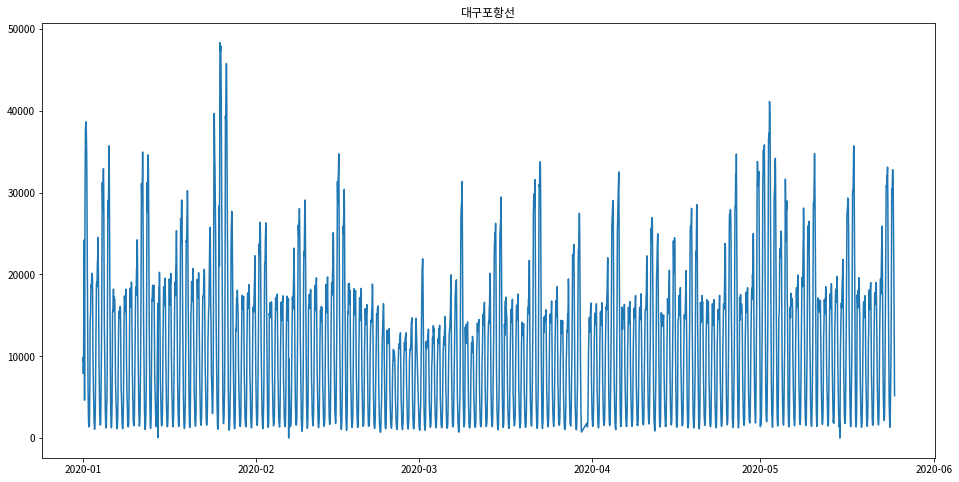

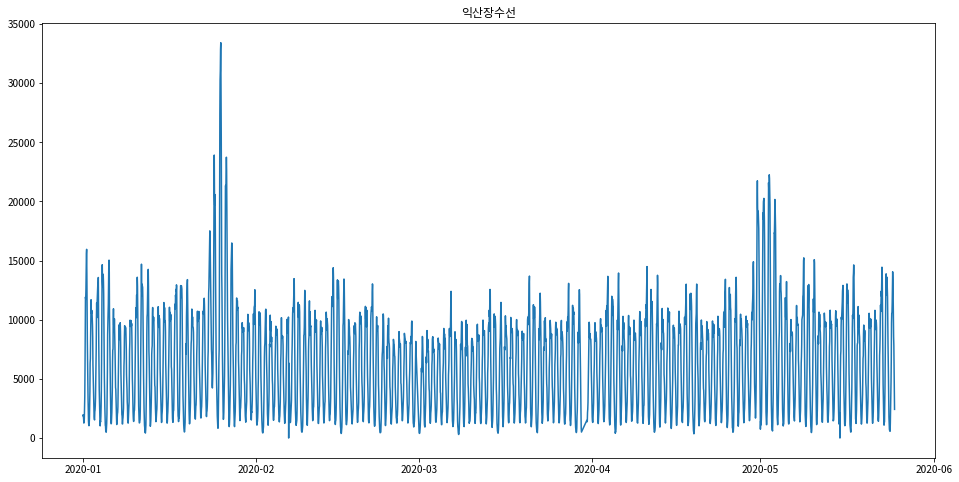

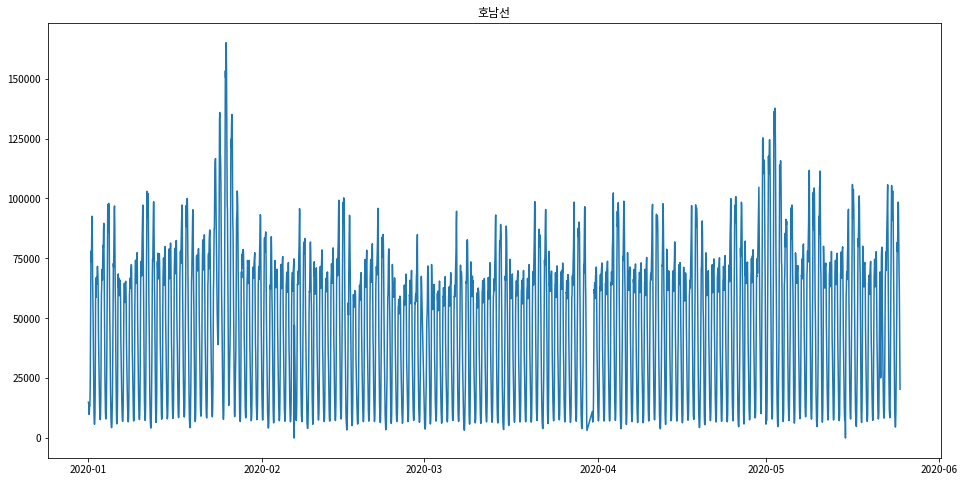

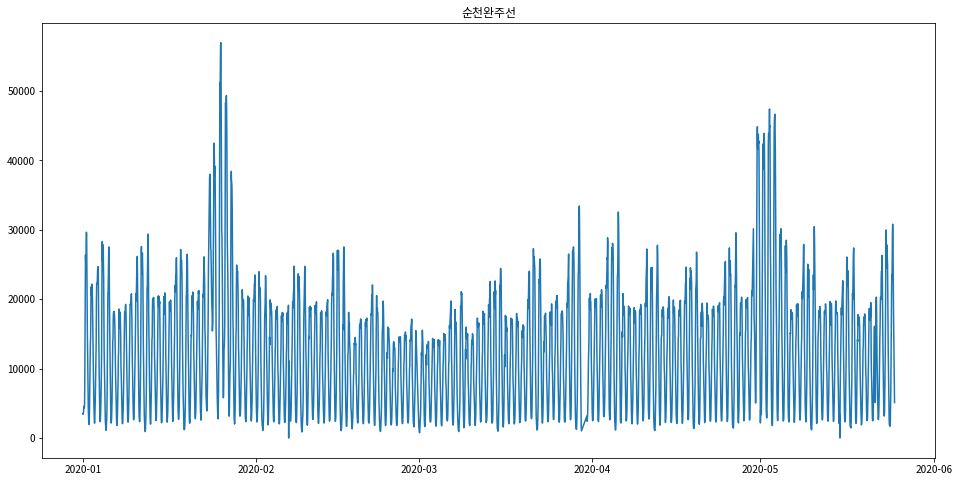

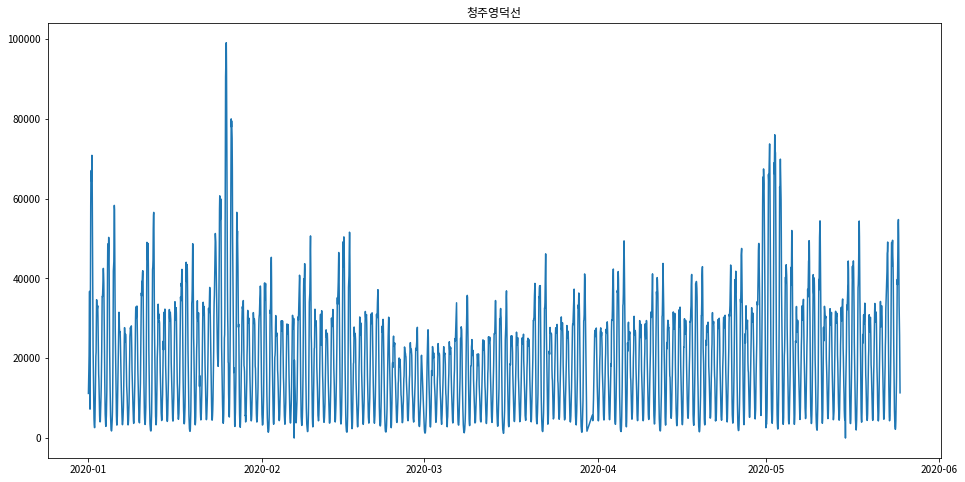

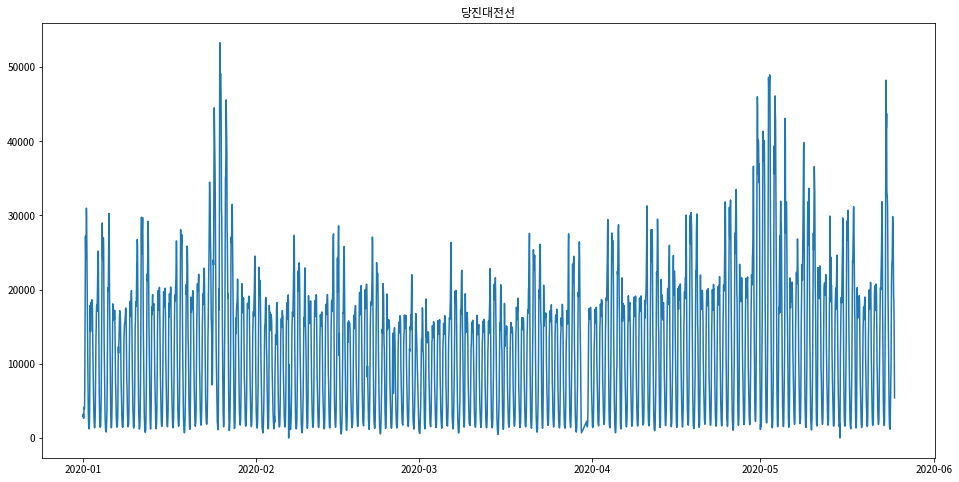

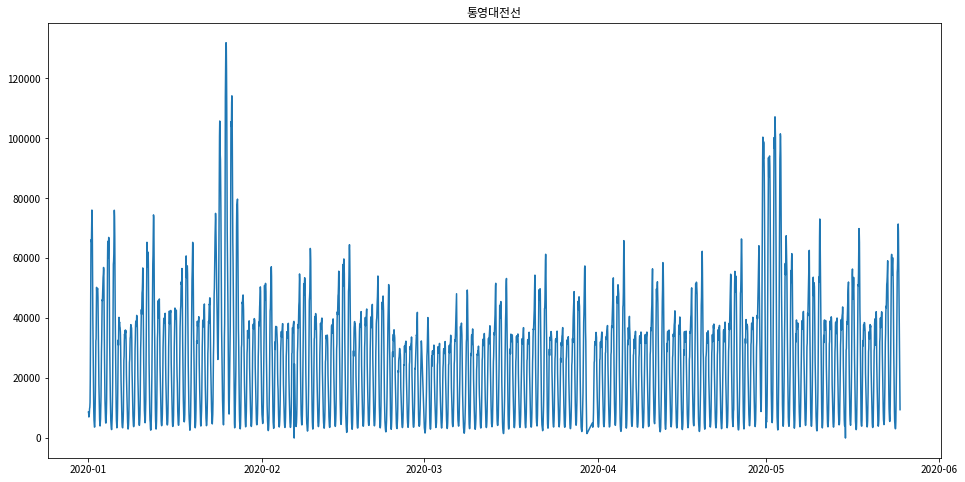

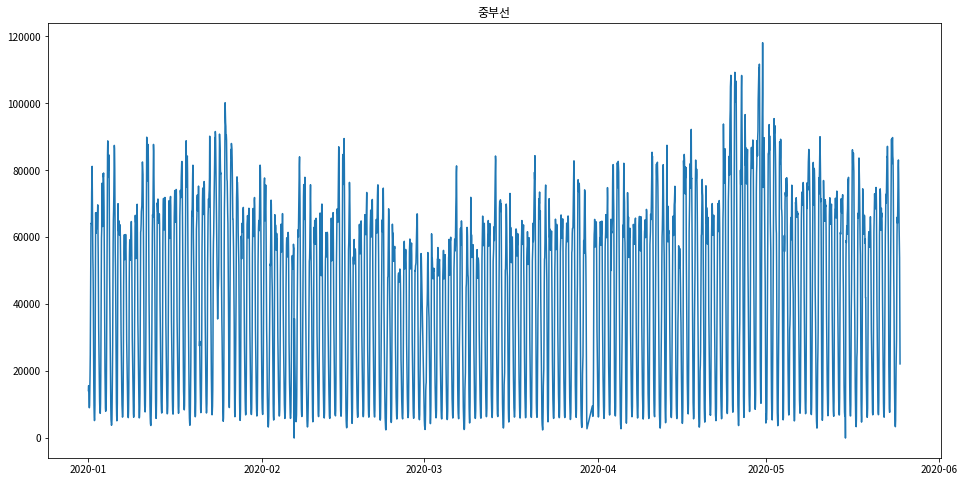

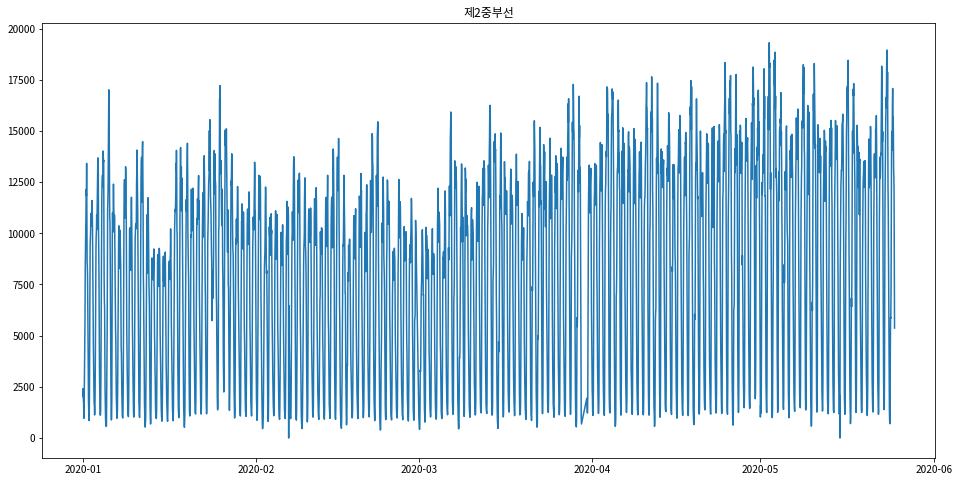

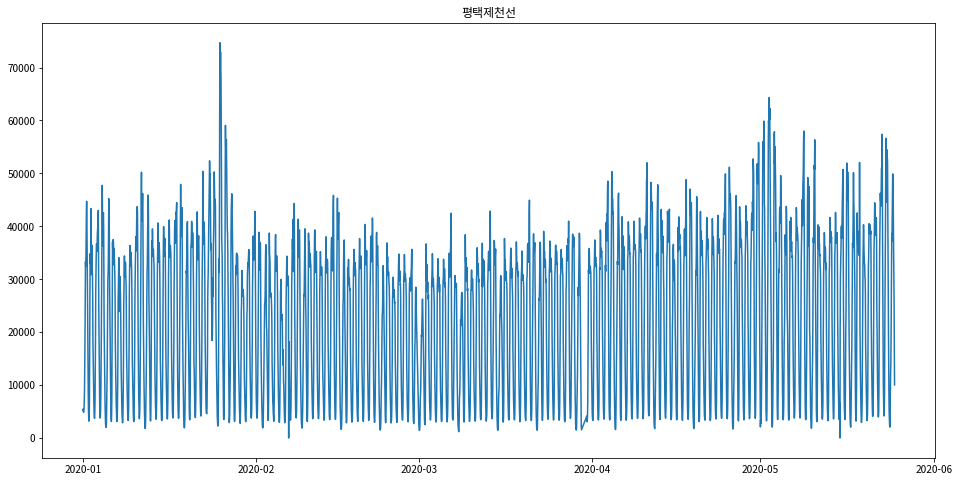

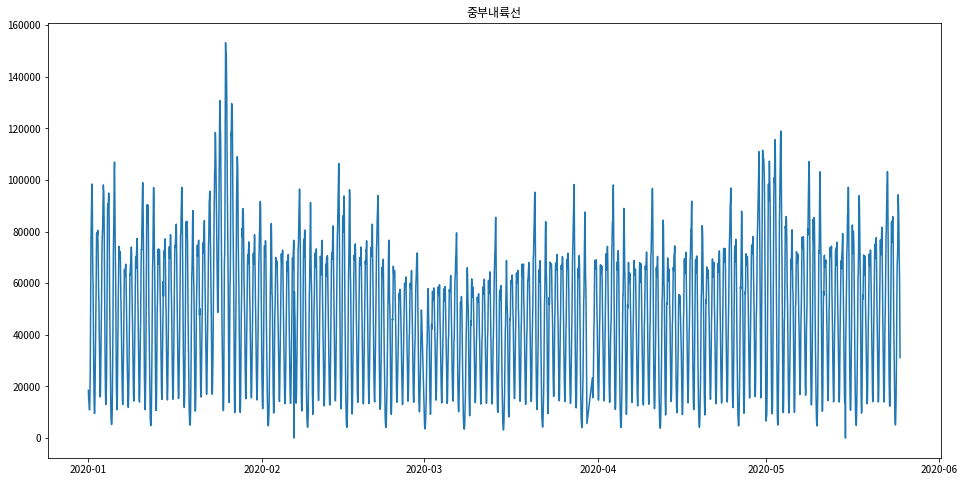

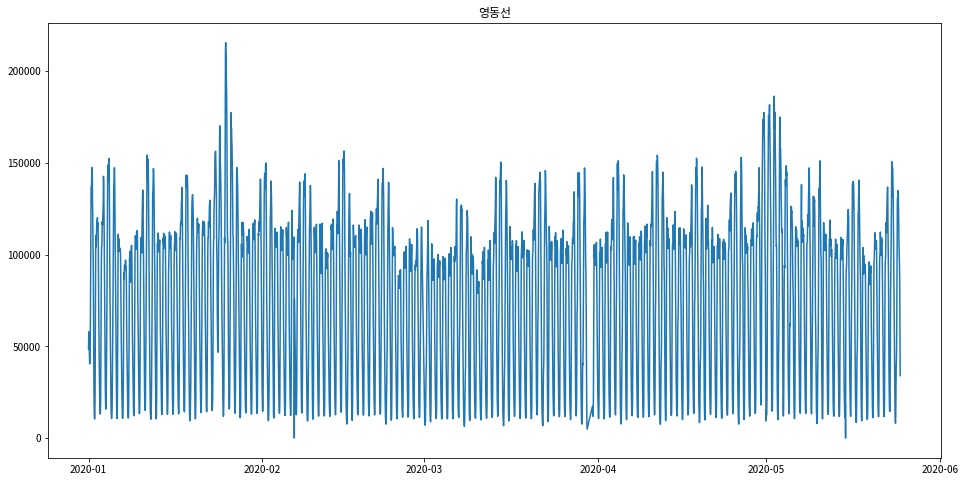

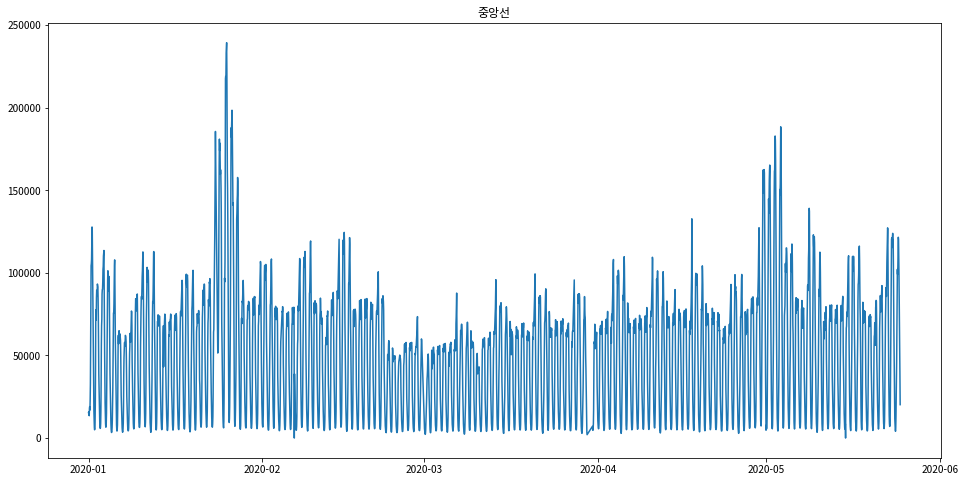

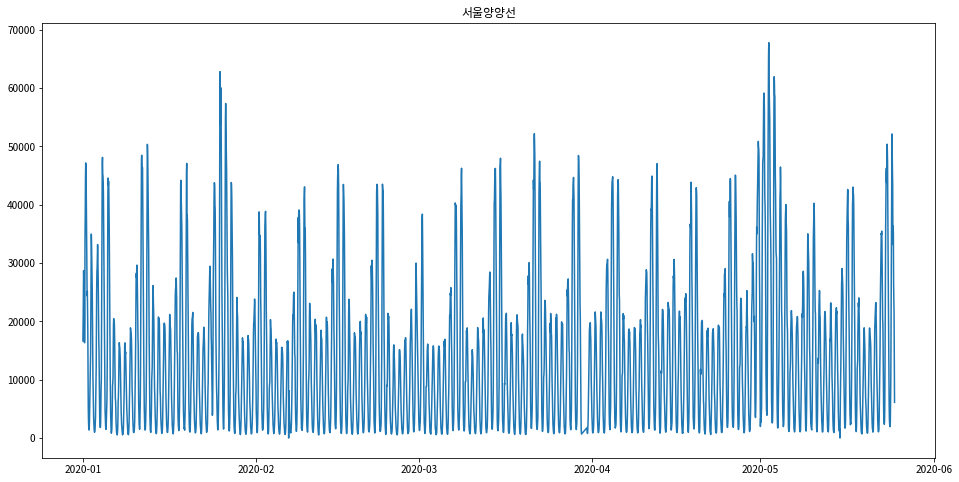

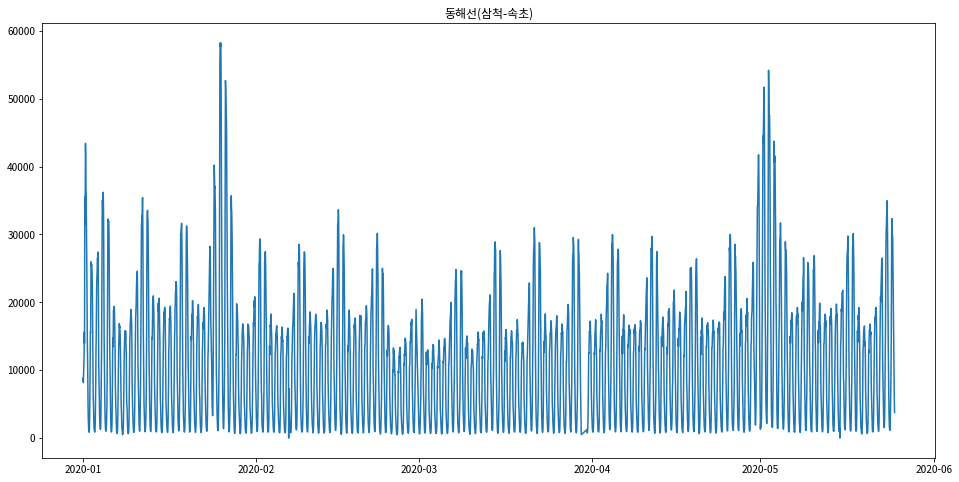

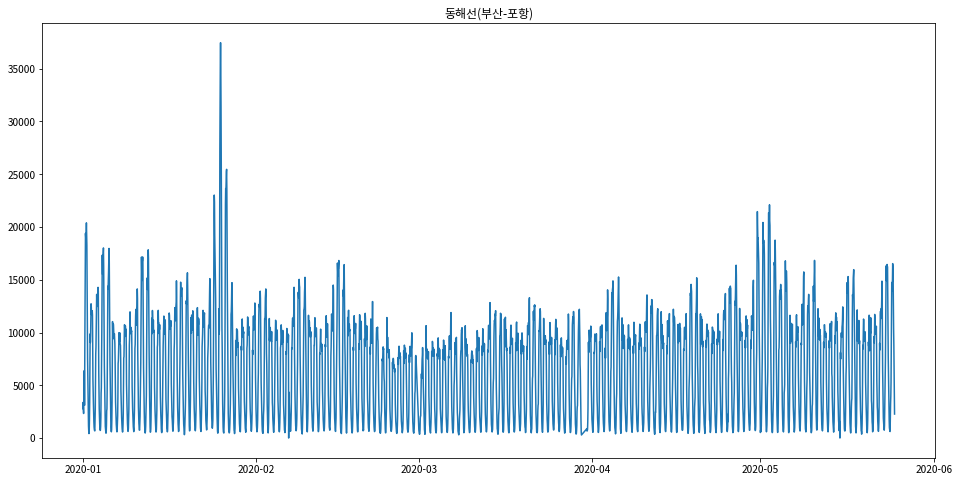

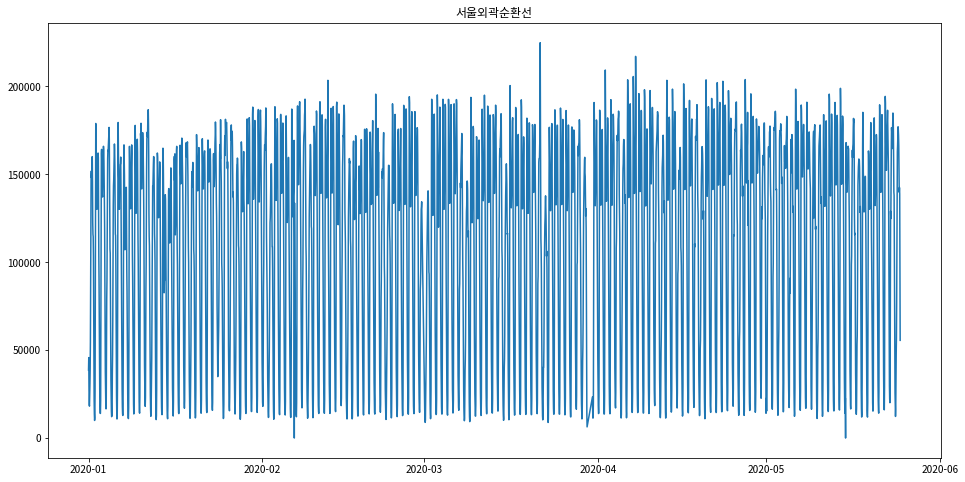

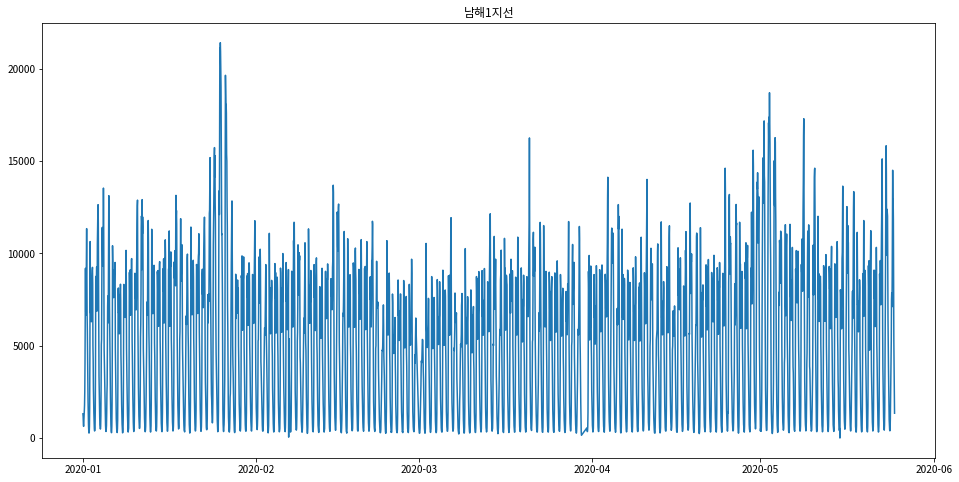

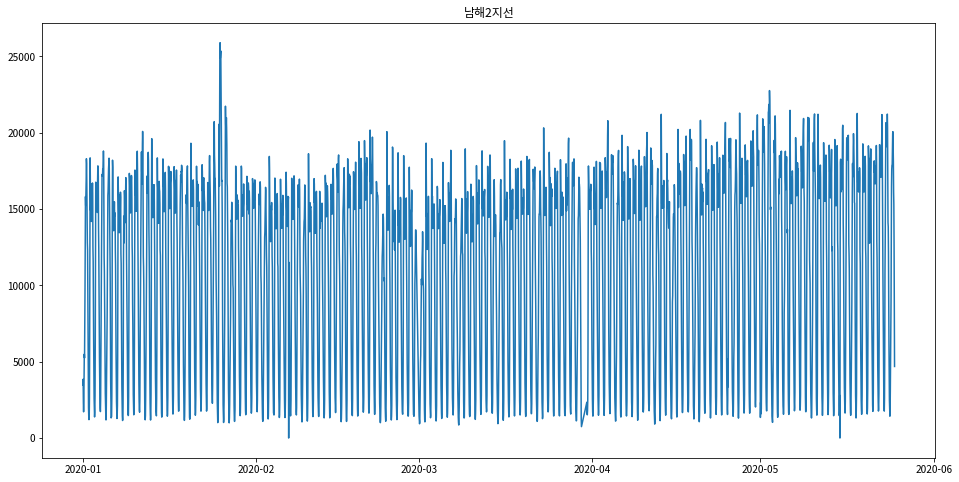

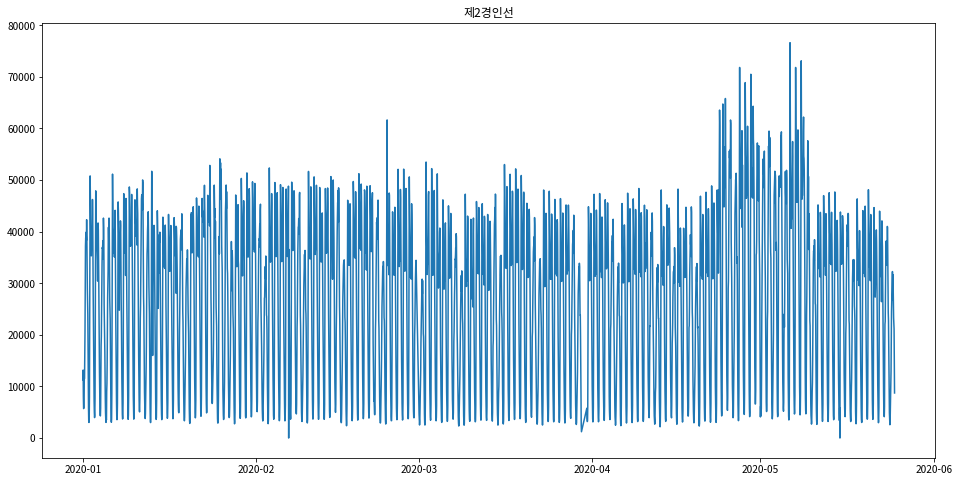

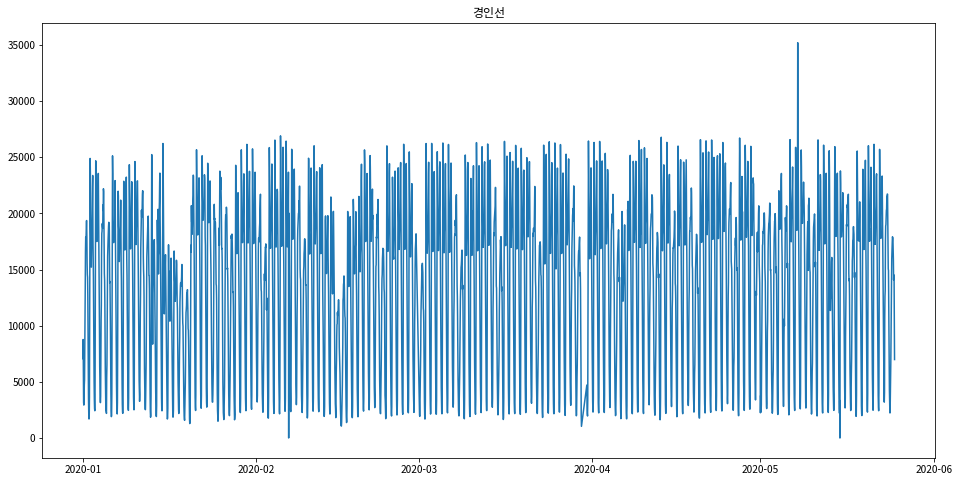

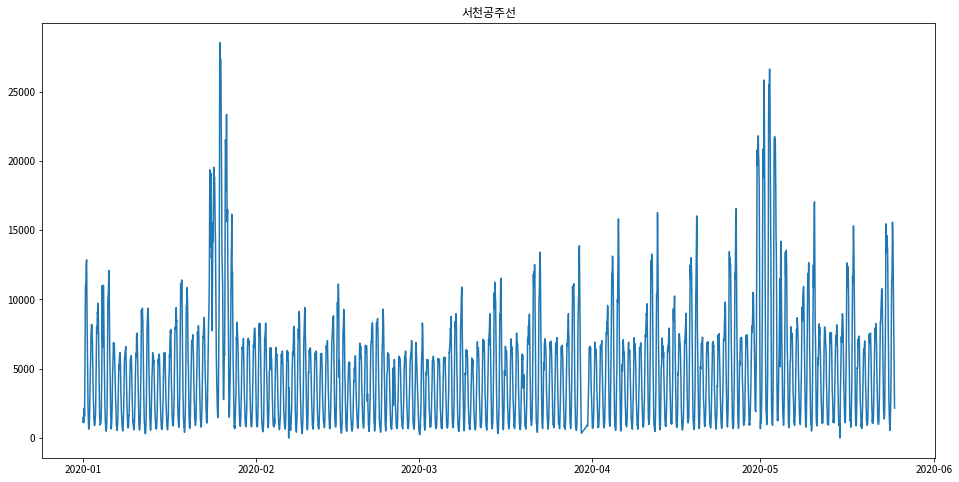

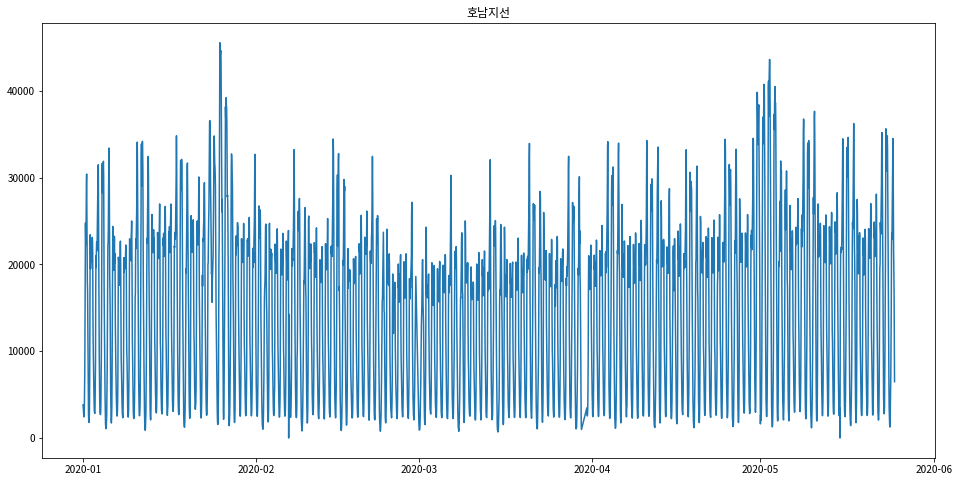

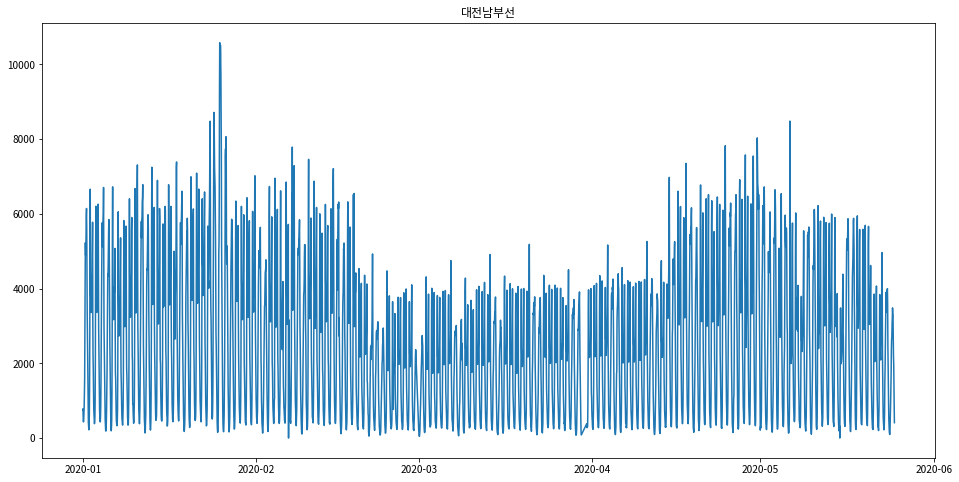

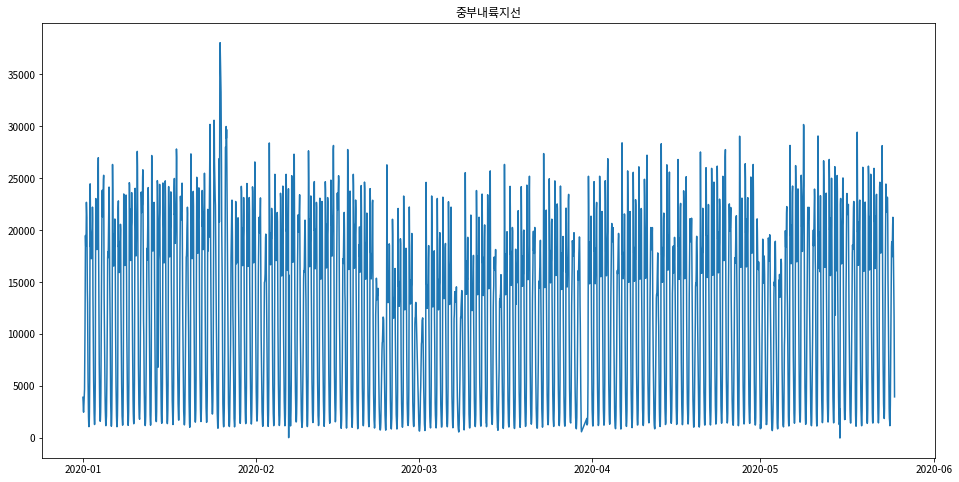

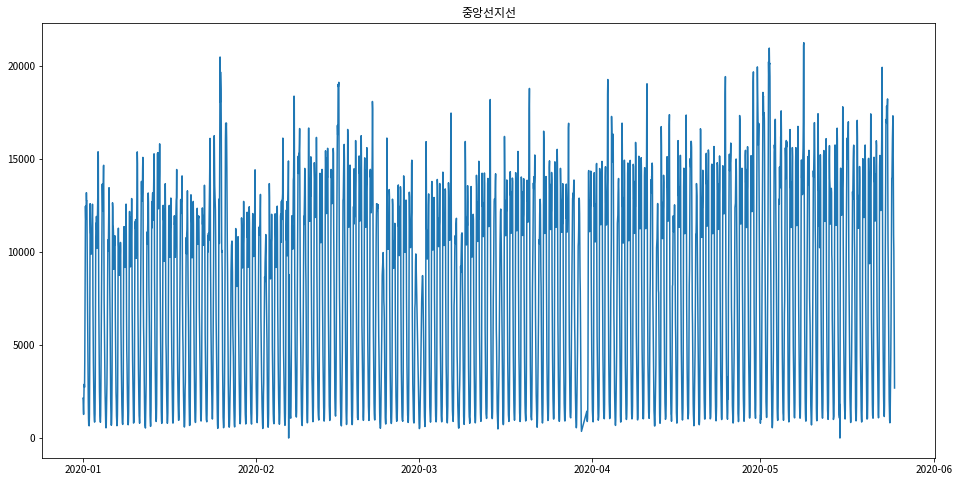

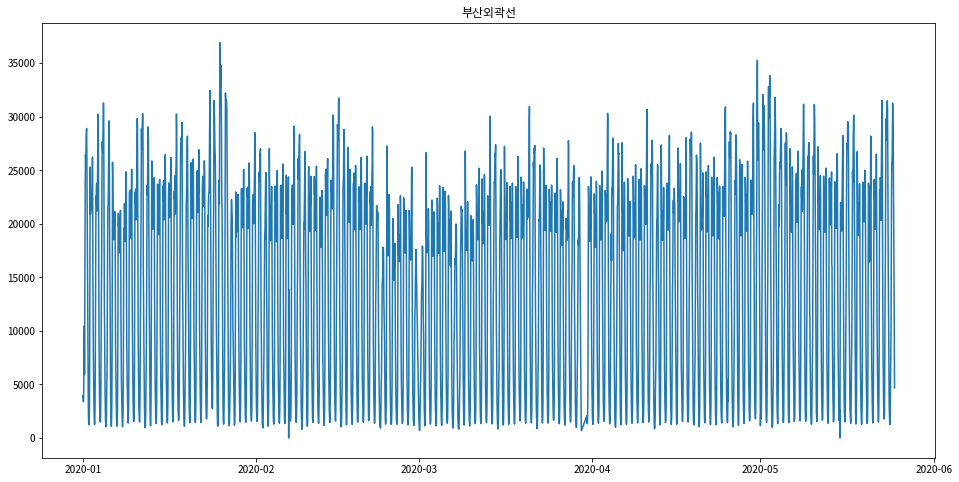

In [18]:
for col in df_train.columns:
    if col not in ['날짜', '시간', '요일', 'datetime']:
        fig, ax = plt.subplots()
        ax.plot('datetime', col, data=df_train, label=highway[col])
        ax.set_title(highway[col])

In [19]:
df_test = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
df_test['datetime'] = df_test.apply(lambda x: pd.to_datetime(f"{x.loc['날짜']}{x.loc['시간']:02d}", format='%Y%m%d%H'), axis=1)
df_test

날짜  시간     10    100   101   120   121   140    150   160  ...  \
0    20200518   0  82065  15172  1500  3294  1086   962  28931  1103  ...   
1    20200518   1  51248   9840   813  2356   696   546  17888   720  ...   
2    20200518   2  39026   7894   760  2413   408   549  13357   498  ...   
3    20200518   3  40993  10137   780  2701   420   741  15544   532  ...   
4    20200518   4  77863  19603  1276  5019   968  1160  32101   968  ...   
..        ...  ..    ...    ...   ...   ...   ...   ...    ...   ...  ...   
331  20200531  19   -999   -999  -999  -999  -999  -999   -999  -999  ...   
332  20200531  20   -999   -999  -999  -999  -999  -999   -999  -999  ...   
333  20200531  21   -999   -999  -999  -999  -999  -999   -999  -999  ...   
334  20200531  22   -999   -999  -999  -999  -999  -999   -999  -999  ...   
335  20200531  23   -999   -999  -999  -999  -999  -999   -999  -999  ...   

     1040  1100  1200  1510  2510  3000  4510  5510  6000            datetime  
0    2790  5147  4331  1329  3665   404  2242  1619  2314 2020-05-18 00:00:00  
1    1864  3269  2561   921  2081   272  1390  1003  1766 2020-05-18 01:00:00  
2    1313  2765  1931   920  1764   228  1136   922  1309 2020-05-18 02:00:00  
3    1766  3320  2060   892  2447   337  1495   975  1912 2020-05-18 03:00:00  
4    2914  6986  3911  1368  4380   513  2940  1758  3629 2020-05-18 04:00:00  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...                 ...  
331  -999  -999  -999  -999  -999  -999  -999  -999  -999 2020-05-31 19:00:00  
332  -999  -999  -999  -999  -999  -999  -999  -999  -999 2020-05-31 20:00:00  
333  -999  -999  -999  -999  -999  -999  -999  -999  -999 2020-05-31 21:00:00  
334  -999  -999  -999  -999  -999  -999  -999  -999  -999 2020-05-31 22:00:00  
335  -999  -999  -999  -999  -999  -999  -999  -999  -999 2020-05-31 23:00:00  

[336 rows x 38 columns]

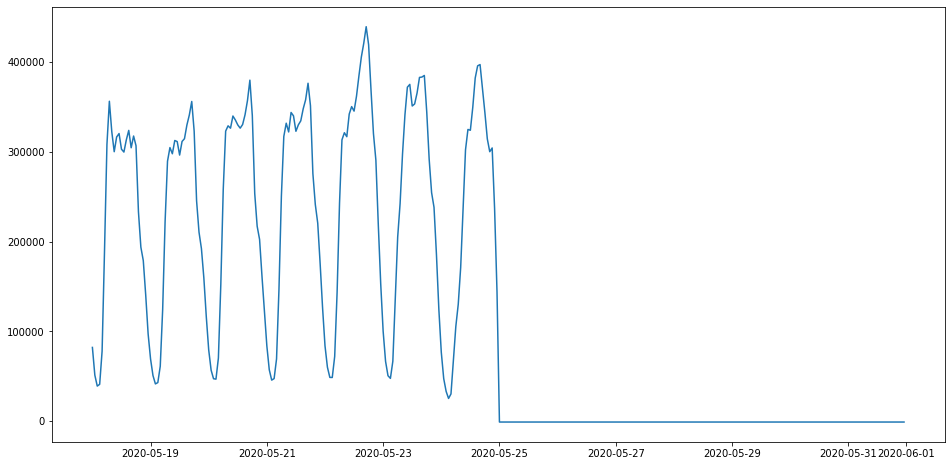

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot('datetime', '10', data=df_test)

## Dataloader
* 한 칼럼에 대한 7일(168행) 데이터를 input_data, 뒤따르는 7일 데이터를 output_data로 반환합니다.
* 도로별 차이를 두지 않고 모든 도로를 동일한 타입의 데이터로 취급합니다.
* 모든 csv 파일의 마지막 168행은 예측해야하는 값이므로 input으로 들어가지 않습니다.

In [13]:
class CustomDataset(data.Dataset):      # torch.utils.data.Dataset 클래스의 상속 클래스 CustomDataset 클래스 생성. 상속 클래스 생성시 __init__, __getitem__, __len__함수는 기본적으로 정의해줘야 함.
    
    def __init__(self, root, seq_len, phase='train'):      # 데이터 로드 단계에 사용될 여러 변수들을 'self.변수명'의 형태로 지정해두는 함수
        
        self.root = root      # CustomDataset 객체 생성 시 데이터 경로 앞부분(공통 부분)을 root로 입력받아 저장
        self.phase = phase      # CustomDataset 객체 생성 시 데이터 경로 뒷부분(train/validate/test)을 phase로 입력받아 저장
        self.label_path = os.path.join(self.root, self.phase + '.csv')      # 데이터 전체 경로 생성
        df = pd.read_csv(self.label_path)      # 생성한 데이터 전체 경로로부터 데이터 로드
        
        self.seq_len = seq_len * 24      # 일 단위 기간을 입력 받은 후 시간 단위 기간으로 변환하여 저장
        self.labels = {}
        
        timestamps = [(i, j) for (i, j) in zip(list(df['날짜']), list(df['시간']))]      # 날짜와 시간 정보가 튜플로 들어 있는 리스트 생성
        categories = df.columns.values.tolist()[2:]      # 도로명 column list 생성

        input_data = []
        output_data = []

        for t in range(len(timestamps)):
            temp_input_data = []
            temp_output_data = []
            for col in categories:
                road = df[col].tolist()
                inp = [float(i) for i in road[t:t+self.seq_len]]      # input 데이터 시계열 구간 설정
                outp = [float(j) for j in road[t+self.seq_len:t+2*self.seq_len]]      # output 데이터 시계열 구간 설정
                temp_input_data.append(inp) 
                temp_output_data.append(outp)
            input_data.append(temp_input_data)
            output_data.append(temp_output_data)
            
# input_data : [[첫번째 input 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 input 기간 동안의 35번째 도로의 통행량 list], ...,
#               [마지막 input 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 input 기간 동안의 35번째 도로의 통행량 list]]
# output_data : [[첫번째 output 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 output 기간 동안의 35번째 도로의 통행량 list], ...,
#                [마지막 output 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 output 기간 동안의 35번째 도로의 통행량 list]]
        
        self.labels['timestamp'] = timestamps
        self.labels['category'] = categories
        self.labels['input'] = input_data
        self.labels['output'] = output_data

    def __getitem__(self, index):      # index를 가지고 데이터를 하나씩 불러올 수 있게 하는 함수

#         데이터 내 index가 부여되는 형태

#                 | road_1    road_2    ...  road_35
#                -------------------------------------
#         time_1  | index_0   index_1   ...  index_34
#         time_2  | index_35  index_36  ...  index_69

        row = index // 35      # index를 35(도로수)로 나눈 몫  ex) 71//35 -> 2
        col = index % 35      # index를 35(도로수)로 나눈 나머지  ex) 71%35 -> 1

        timestamp = self.labels['timestamp'][row]      # (날짜, 시간) 튜플이 들어있는 list에서 row번째 시점에 해당하는 튜플
        category = self.labels['category'][col]      # 도로명 column list에서 col번째 도로에 해당하는 element
        
        input_data = torch.tensor(self.labels['input'][row][col])      # input_data list에서, row번째 시점의 col번째 도로 교통량 정보

        if self.phase != 'test':
            output_data = torch.tensor(self.labels['output'][row][col])
        else:
            output_data = []

        return timestamp, category, (input_data, output_data)

    def __len__(self):      # getitem 함수를 통해 데이터를 불러오려면,전체 index 길이를 알아야 한다.
        return (len(self.labels['timestamp']) - (self.seq_len * 2) + 1) * 35      # 특정 시점이 아닌 특정 기간을 하나의 data 단위로 설정하면, 전체 샘플 수는 감소함을 반영 


def data_loader(root, phase='train', batch_size=64, seq_len=7, drop_last=False):
    if phase == 'train':
        shuffle = True
    else:
        shuffle = False

    dataset = CustomDataset(root, seq_len, phase)
    dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return dataloader

## Model

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class LSTMNet(nn.Module):      # torch.nn.Module 클래스의 상속 class LSTMNet class 생성. 상속 클래스 생성시 __init__, forward 함수는 기본적으로 정의해줘야 함.
    def __init__(self,
                 input_size=168,      # input 길이는 168시간(7일 X 24시간)
                 hidden_size=1024,
                 output_size=168,      # output 길이는 168시간(7일 X 24시간)
                 num_layers=3,
                 dropout=0,
                 batch_first=False):      # batch_first(default=False) : 배치 차원을 첫번째 차원으로 하여 데이터를 불러올 것인지 여부

        super(LSTMNet, self).__init__()

        self.hidden_size = hidden_size
        
        ##### Layer 1
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             dropout=0.2,
                             num_layers=num_layers)

        ##### Layer 2
        self.lstm2 = nn.LSTM(hidden_size, 
                             hidden_size,
                             dropout=0.2,
                             num_layers=num_layers)

        ##### Finalize
        self.linear = nn.Linear(hidden_size, 
                                output_size)
        
        self.activation = nn.LeakyReLU(0.2)

        
    def forward(self, x, h_in, c_in):      # forward 함수를 직접 호출할 일은 없음. model = LSTMNet() 객체를 생성한 다음, 
                                           # predictions, (h2, c_2) = model(input_data, h_in, c_in) 형태로 return을 받으면 됨

        h_in = nn.Parameter(h_in.type(dtype), requires_grad=True)      # gradient descent로 업데이트 되는(requires_grad=True), hidden state 초기값 파라미터 생성 
        c_in = nn.Parameter(c_in.type(dtype), requires_grad=True)      # gradient descent로 업데이트 되는(requires_grad=True), cell state 초기값 파라미터 생성

        # Layer 1
        lstm_out, (h_1, c_1) = self.lstm1(x, (h_in, c_in))
        lstm_out = self.activation(lstm_out)

        # Layer2
        lstm_out, (h_2, c_2) = self.lstm2(lstm_out, (h_1, c_1))
        lstm_out = self.activation(lstm_out)

        # Final
        predictions = self.linear(lstm_out)
        
        return predictions, (h_2, c_2)

In [15]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, os.path.join('log', model_name + '.pth'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join(model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

## Hyperparameters

In [16]:
dtype = torch.float
num_epochs = 5
base_lr = 0.01
seq_len = 7

input_size = seq_len * 24
hidden_size = 1024
output_size = input_size
batch_size = 64
num_layers = 6

## Training Setting

In [17]:
# model
model = LSTMNet(input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                num_layers=num_layers)

model = model.to(device)

# loss function
criterion = nn.MSELoss()      # 플랫폼 상 채점은 RMSE, 즉 MSE에 root를 씌운 값이기 때문에 사실상 평가지표와 같은 Loss입니다.

# optimizer
optimizer = Adam(model.parameters(), lr=base_lr)      # optimizer로는 Adam이 가장 무난합니다. Adam을 쓰면 learning_rate를 따로 지정해주지 않아도 알아서 조정됩니다.

In [18]:
print(model)

LSTMNet(
  (lstm1): LSTM(168, 1024, num_layers=6, dropout=0.2)
  (lstm2): LSTM(1024, 1024, num_layers=6, dropout=0.2)
  (linear): Linear(in_features=1024, out_features=168, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


In [19]:
# get data loader
train_dataloader = data_loader(root=DATASET_PATH,
                               phase='train',
                               batch_size=batch_size,
                               seq_len=seq_len,
                               drop_last=True)

validate_dataloader = data_loader(root=DATASET_PATH,
                                  phase='validate',
                                  batch_size=1,
                                  seq_len=seq_len,
                                  drop_last=True)

## Train

In [20]:
train_batch_loss = 0.0      # 400 batch마다 평균 training loss를 확인한 다음, train_batch_loss를 0으로 갱신해줄 것
train_epoch_loss = 0.0      # 1 epoch마다 평균 training loss를 확인한 다음, train_epoch_loss를 0으로 갱신해줄 것

valid_epoch_loss = 0.0      # 1 epoch마다 평균 validation loss를 확인한 다음, valid_epoch_loss를 0으로 갱신해줄 것
valid_min_epoch_loss = np.inf      # 초기 loss를 마이너스 무한대로 설정해두고, validation epoch loss가 낮아질 때마다 갱신해줄 것


for epoch in range(num_epochs):

    model.train()      # 모델을 train mode로 전환. train mode일 때만 적용되어야 하는 drop out 등이 적용될 수 있게 하기 위함 

    for iter_, sample in enumerate(train_dataloader):      # enumerate 함수를 통해 train_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

        (h_in, c_in) = (torch.zeros(num_layers, batch_size, hidden_size, requires_grad=True).to(device),
                        torch.zeros(num_layers, batch_size, hidden_size, requires_grad=True).to(device))

        _, _, (input_data, output_data) = sample      # train_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨.
                                                      # 학습에는 [[input_data], [output_data]]만 사용
        
        input_data = input_data.unsqueeze(0).to(device)
        output_data = output_data.unsqueeze(0).to(device)

        pred, (h_in, c_in) = model(input_data, h_in, c_in)
        
        loss = criterion(pred, output_data)

        model.zero_grad()    # 파라미터 업데이트는 batch 단위로 이루어지고, 매 batch마다 gradient를 초기화해주어야 함 
        loss.backward()      # backpropagation
        optimizer.step()      # 파라미터 업데이트
        
        train_batch_loss += loss.item()
        train_epoch_loss += loss.item()

        if iter_ % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch, iter_+1, train_batch_loss/400))
            train_batch_loss = 0
            
    train_epoch_loss = 0.0      # training epoch마다 train_epoch_loss 새로 구해줄 것

    
    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언
        (h_in, c_in) = (torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device),
                        torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device))

        for iter_, sample in enumerate(validate_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            _, _, (input_data, output_data) = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.unsqueeze(0).to(device)
            output_data = output_data.unsqueeze(0).to(device)

            pred, (h_in, c_in) = model(input_data, h_in, c_in)
            loss = criterion(pred, output_data)
            valid_epoch_loss += loss.item()

        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch, valid_epoch_loss/len(validate_dataloader)))

        if valid_epoch_loss < valid_min_epoch_loss:
            save_model('best', model, optimizer)
            valid_min_epoch_loss = valid_epoch_loss

        valid_epoch_loss = 0.0

Train Epoch:  0 | Batch:  400 | Loss: 3749772544.00
Train Epoch:  0 | Batch:  800 | Loss: 3635597354.40
Train Epoch:  0 | Batch: 1200 | Loss: 3558327704.64
Train Epoch:  0 | Batch: 1600 | Loss: 3453729056.16

Valid Epoch:  0 | Loss: 3653977674.14
model saved

Train Epoch:  1 | Batch:  400 | Loss: 3353510724.32
Train Epoch:  1 | Batch:  800 | Loss: 3428555045.92
Train Epoch:  1 | Batch: 1200 | Loss: 3296155791.36
Train Epoch:  1 | Batch: 1600 | Loss: 3206721782.56

Valid Epoch:  1 | Loss: 3244910816.11
model saved

Train Epoch:  2 | Batch:  400 | Loss: 3258923734.24
Train Epoch:  2 | Batch:  800 | Loss: 2991087424.72
Train Epoch:  2 | Batch: 1200 | Loss: 2946948664.00
Train Epoch:  2 | Batch: 1600 | Loss: 2867190943.20

Valid Epoch:  2 | Loss: 3035766007.31
model saved

Train Epoch:  3 | Batch:  400 | Loss: 2987906708.96
Train Epoch:  3 | Batch:  800 | Loss: 2839159956.96
Train Epoch:  3 | Batch: 1200 | Loss: 2806189701.52
Train Epoch:  3 | Batch: 1600 | Loss: 2917531952.32

Valid Epoch

## Inference

In [21]:
dtype = torch.float
seq_len = 7

input_size = seq_len * 24
hidden_size = 1024
output_size = input_size
batch_size = 1
num_layers = 6

In [22]:
test_dataloader = data_loader(root=DATASET_PATH,
                              phase='test',
                              batch_size=batch_size,
                              seq_len=seq_len,
                              drop_last=True)

In [23]:
model = LSTMNet(input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                num_layers=num_layers)

# model
model_name = 'log/best.pth'

load_model(model_name, model)
model = model.to(device)

model loaded


In [24]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [25]:
(h_in, c_in) = (torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device),
                torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device))

for iter_, sample in enumerate(test_dataloader):

    timestamp, category, (input_data, output_data) = sample
    input_data = input_data.unsqueeze(0).to(device)

    pred, (h_in, c_in) = model(input_data, h_in, c_in)

    for i, (t, h) in enumerate(zip(timestamp[0], timestamp[1])):
        for cat, row in zip(category, pred[0]):
            cat = f'{cat}'
            submission_table[cat] = row.tolist()

In [26]:
submission_table.to_csv('prediction.csv', index=False)